In [1]:
from Functions.fn_basic import *
from Functions.fn_stats import *
from Functions.fn_plots import *

import os, mne
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from scipy import stats

from statannotations.Annotator import Annotator
import statannotations

In [2]:
#exp_folder = input('Experiment folder (e.g., Eyes Open\Baseline):')
exp_folder_1 = r"Eyes Closed\Baseline"
exp_folder_2 = r"Eyes Closed\6 weeks"
exp_folder_3 = r"Eyes Closed\10 weeks"

psd_reg_folder = r"Results\PSD\regions"
psd_ch_folder = r"Results\PSD\channels"

condition_code_list = [['EC_00','EC_06'],['EC_06','EC_07'],['EC_00','EC_07']]

[dir_inprogress_reg_1,b_names_reg_1,condition_reg_1] = readPSDFiles(exp_folder_1,psd_reg_folder)
[dir_inprogress_reg_2,b_names_reg_2,condition_reg_2] = readPSDFiles(exp_folder_2,psd_reg_folder)
[dir_inprogress_reg_3,b_names_reg_3,condition_reg_3] = readPSDFiles(exp_folder_3,psd_reg_folder)

dir_inprogress_reg = dir_inprogress_reg_1,dir_inprogress_reg_2,dir_inprogress_reg_3
b_names_reg = b_names_reg_1,b_names_reg_2,b_names_reg_3
condition_reg = condition_reg_1,condition_reg_2,condition_reg_3

[dir_inprogress_ch_1,b_names_ch_1,condition_ch_1] = readPSDFiles(exp_folder_1,psd_ch_folder)
[dir_inprogress_ch_2,b_names_ch_2,condition_ch_2] = readPSDFiles(exp_folder_2,psd_ch_folder)
[dir_inprogress_ch_3,b_names_ch_3,condition_ch_3] = readPSDFiles(exp_folder_3,psd_ch_folder)

dir_inprogress_ch = dir_inprogress_ch_1,dir_inprogress_ch_2,dir_inprogress_ch_3
b_names_ch = b_names_ch_1,b_names_ch_2,b_names_ch_3
condition_ch = condition_ch_1,condition_ch_2,condition_ch_3

clean_folder = r"Data\Clean"
dir_inprogress_epo = os.path.join(clean_folder,exp_folder_1)
_, subject_names = readFiles(dir_inprogress_epo,"_clean-epo.fif")
epochs = mne.read_epochs(fname='{}\{}_clean-epo.fif'.format(dir_inprogress_epo,subject_names[0]))

Files in folder: 5
Files in folder: 5
Files in folder: 5
Files in folder: 5
Files in folder: 5
Files in folder: 5
Files in folder: 26
Reading c:\Users\TANIJARV\Downloads\Ketamine-SI project\eeg-pipeline\Data\Clean\Eyes Closed\Baseline\OKTOS_0001_00A_EC_clean-epo.fif ...
    Read a total of 1 projection items:
        EOG-eeg--0.200-0.200-PCA-01 (1 x 32) active
    Found the data of interest:
        t =       0.00 ...    4999.02 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
52 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [3]:
df_psd_reg = pd.DataFrame()
for i in range(len(b_names_reg[0])):
    for n_exps in range(len(b_names_reg)):
        globals()[b_names_reg[n_exps][i]] = pd.read_excel('{}\{}.xlsx'\
                                            .format(dir_inprogress_reg[n_exps],b_names_reg[n_exps][i]))\
            .assign(**{'Frequency band': condition_reg[n_exps][i][1],'Condition': condition_reg[n_exps][i][0]})
        df_psd_reg = pd.concat([df_psd_reg,globals()[b_names_reg[n_exps][i]]])

for condition in condition_code_list:
    df_reg_pvals,significant_reg = paired_Ttest(df_psd_reg,condition)
    try:
        os.makedirs(os.path.join(psd_reg_folder,''))
    except FileExistsError:
        pass
    df_reg_pvals.to_excel(r"Results\PSD\regions\p-values_{}-{}.xlsx".format(condition[0],condition[1]))

Significant changes of Low-Beta are at ['Frontal']
Significant changes of Alpha are at ['Temporal' 'Centro-parietal']
Significant changes of Delta are at ['Temporal']
Significant changes of Low-Beta are at ['Centro-parietal' 'Occipital']
Significant changes of Theta are at ['Temporal']


In [4]:

df_psd_ch = pd.DataFrame()
for i in range(len(b_names_ch[0])):
    for n_exps in range(len(b_names_ch)):
        globals()[b_names_ch[n_exps][i]] = pd.read_excel('{}\{}.xlsx'\
                                            .format(dir_inprogress_ch[n_exps],b_names_ch[n_exps][i]))\
            .assign(**{'Frequency band': condition_ch[n_exps][i][1],'Condition': condition_ch[n_exps][i][0]})
        df_psd_ch = pd.concat([df_psd_ch,globals()[b_names_ch[n_exps][i]]])

for condition in condition_code_list:
    df_ch_pvals,significant_ch = paired_Ttest(df_psd_ch,condition)
    try:
        os.makedirs(os.path.join(psd_ch_folder,''))
    except FileExistsError:
        pass
    df_ch_pvals.to_excel(r"Results\PSD\channels\p-values_{}-{}.xlsx".format(condition[0],condition[1]))

Significant changes of Alpha are at ['Pz']
Significant changes of Delta are at ['P8' 'T8']
Significant changes of High-Beta are at ['FC1']
Significant changes of Low-Beta are at ['FC1' 'Pz']
Significant changes of Alpha are at ['F7' 'FC5' 'T7' 'C3' 'CP5' 'P7' 'P3' 'PO3' 'P4' 'P8' 'CP6' 'C4' 'T8'
 'FC6' 'F8']
Significant changes of Delta are at ['P8' 'T8']
Significant changes of Low-Beta are at ['PO3' 'O2' 'PO4' 'P4' 'CP6' 'FC6' 'F4']
Significant changes of Theta are at ['O2' 'PO4' 'P4' 'P8' 'CP6' 'T8']
Significant changes of Low-Beta are at ['Fp1']


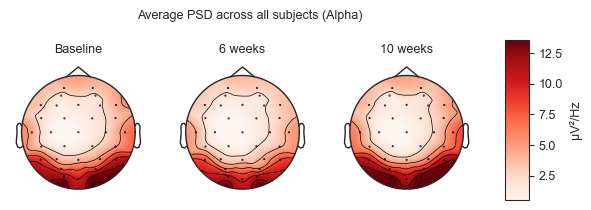

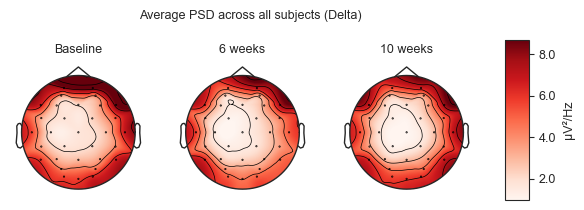

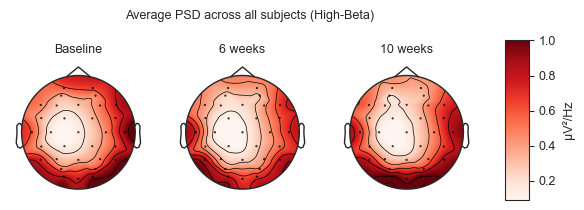

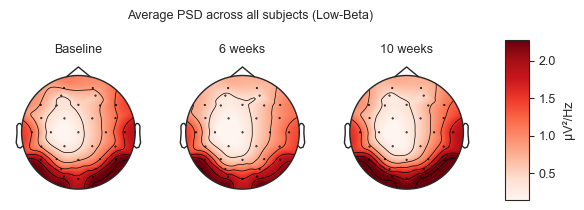

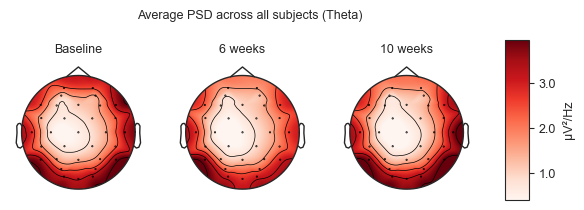

In [5]:
for b_name in (df_psd_ch['Frequency band'].unique()):
    plot_topomaps_band(df_psd_ch,epochs,b_name,condition_legend=['Baseline','6 weeks','10 weeks'],
                       conditions=['EC_00','EC_06','EC_07'],fnt=['sans-serif',9],export=True)

Significant changes of Alpha are at ['Centro-parietal']
Significant changes of Low-Beta are at ['Centro-parietal']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Alpha_EC_06 vs. Alpha_EC_07: t-test paired samples, P_val:1.503e-02 t=-2.611e+00


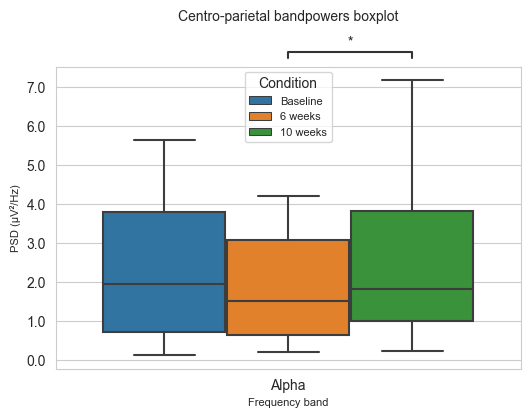

In [6]:
plot_boxplot_location(df_psd_reg,bands=['Alpha'],region='Centro-parietal',
                      condition_comp_list=condition_code_list,
                      condition_legend=['Baseline','6 weeks','10 weeks'],fnt=['sans-serif',8,10],
                      stat_test='t-test_paired',ast_loc='outside',export=True)

Significant changes of Low-Beta are at ['Frontal']
Significant changes of Low-Beta are at ['Centro-parietal' 'Occipital']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Centro-parietal_EC_06 vs. Centro-parietal_EC_07: t-test paired samples, P_val:4.470e-02 t=-2.114e+00
Occipital_EC_06 vs. Occipital_EC_07: t-test paired samples, P_val:3.163e-02 t=-2.277e+00
Frontal_EC_00 vs. Frontal_EC_06: t-test paired samples, P_val:4.331e-02 t=2.129e+00


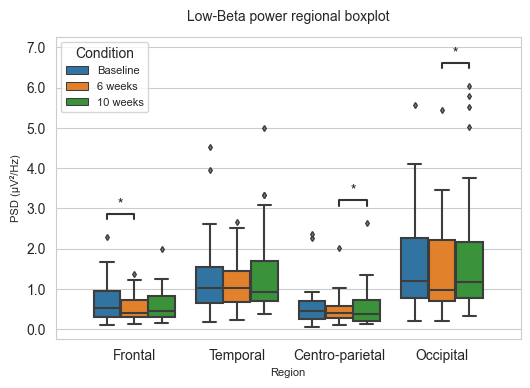

In [7]:
plot_boxplot_band(df_psd_reg,regions=['Frontal','Temporal','Centro-parietal','Occipital'],band='Low-Beta',
                  condition_comp_list=condition_code_list,
                  condition_legend=['Baseline','6 weeks','10 weeks'],fnt=['sans-serif',8,10],
                  stat_test='t-test_paired',ast_loc='inside',export=True)


Significant changes of Low-Beta are at ['FC1' 'Pz']
Significant changes of Low-Beta are at ['PO3' 'O2' 'PO4' 'P4' 'CP6' 'FC6' 'F4']
Significant changes of Low-Beta are at ['Fp1']
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Fp1_EC_00 vs. Fp1_EC_07: t-test paired samples, P_val:4.880e-02 t=2.071e+00


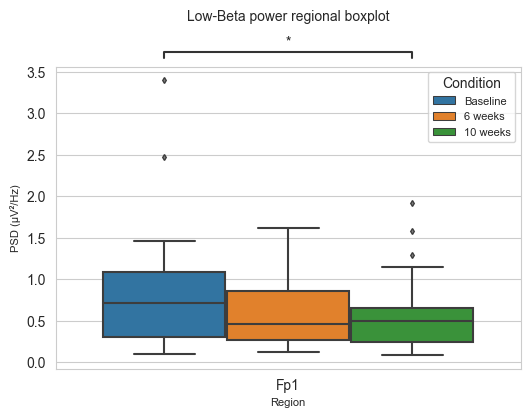

In [8]:
plot_boxplot_band(df_psd_ch,regions=['Fp1'],band='Low-Beta',
                  condition_comp_list=condition_code_list,
                  condition_legend=['Baseline','6 weeks','10 weeks'],fnt=['sans-serif',8,10],
                  stat_test='t-test_paired',ast_loc='outside',export=True)

In [ ]:
plt.figure()
ax = sns.violinplot(x='Frequency band', y='Frontal',
                 hue='Condition',
                 data=df_psd_reg[df_psd_reg['Frequency band'] == 'Low-Beta'])
ax = sns.swarmplot(x='Frequency band', y='Frontal',
                   hue='Condition', color='0.01', dodge=True,
                   data=df_psd_reg[df_psd_reg['Frequency band'] == 'Low-Beta'])